> __Purpose:__ Plot Adversarial Decoder ML Model Accuracy VS User Error, observe if one converges faster than the other, thus indicating we could gain privacy by stopping the personalization earlier (e.g. stopping the decoder from further personalizing and letting it continue to use the given "acceptable" decoder for good enough performance).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data

In [2]:
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

with open('Data\cphs_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, poss_block1, _, _, _, Ws_block1, _, _, _, times_block1, _ = pickle.load(handle)

with open('Data\cphs_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    refs_block2, poss_block2, _, _, _, Ws_block2, _, _, _, times_block2, _ = pickle.load(handle)
    
update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]


In [3]:
# learning rate conditions
slow = [4, 5, 6, 7] # slow --> alpha = 0.75 bc 
fast = [0, 1, 2, 3]
# initialization conditions
pos_init = [0, 1, 4, 5]
neg_init = [2, 3, 6, 7]
# penalty parameter conditions
pD_3 = [0, 2, 4, 6] # pD = 1e-3
pD_4 = [1, 3, 5, 7] # pD = 1e-4

# Took these from 000, look at that NB to see how they are calculated
conds = ['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7', 'D_8']
min_time = 20770
RAMP = 350
tscale = 70.08502828627614

# choosing some random subject/condition that's done reasonably well (a.k.a. "representative subject")
k = keys[0]
c = 6
print(k)
print(conds[c])

# first minute
s0 = 0
s1 = int(min_time/5)

# last minute
s2 = int(4/5*min_time)
s3 = min_time

METACPHS_S106
D_7


## Plot Accuracy As a Func of N

In [4]:
# df = pd.read_pickle(file_name)
lr_df = pd.read_pickle(r"Data\104_lr_df.pkl")
knn_df = pd.read_pickle(r"Data\104_knn_df.pkl")
svc_df = pd.read_pickle(r"Data\104_svc_df.pkl")
dt_df = pd.read_pickle(r"Data\104_dt_df.pkl")
gbt_df = pd.read_pickle(r"Data\104_gbt_df.pkl")

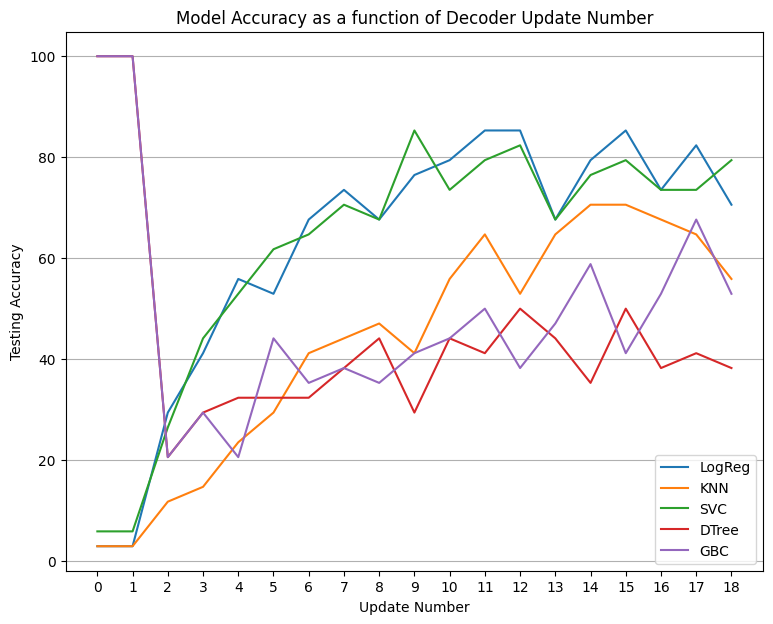

In [5]:
plt.figure(figsize=(9,7))
plt.plot(list(range(19)), lr_df.iloc[:, 2], label='LogReg')
plt.plot(list(range(19)), knn_df.iloc[:, 2], label='KNN')
plt.plot(list(range(19)), svc_df.iloc[:, 2], label='SVC')
plt.plot(list(range(19)), dt_df.iloc[:, 2], label='DTree')
plt.plot(list(range(19)), gbt_df.iloc[:, 2], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

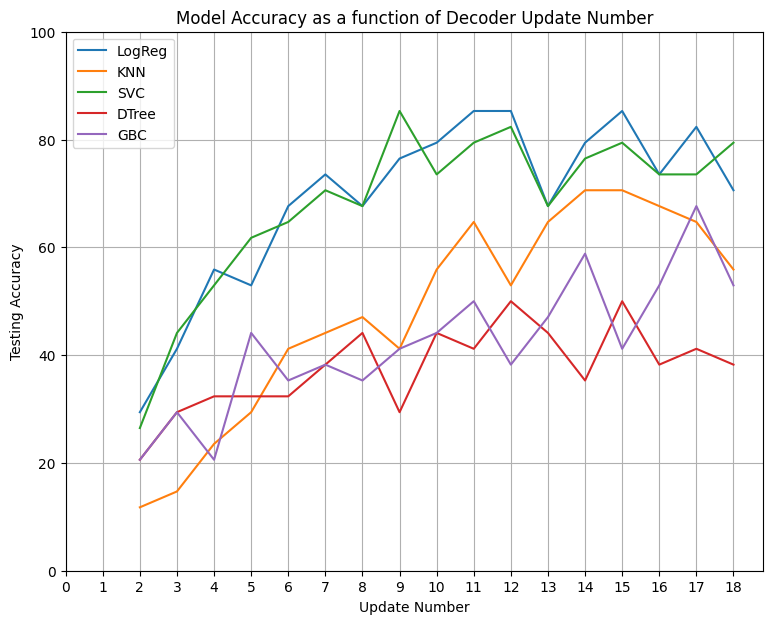

In [69]:
my_x_updates = list(range(19))[2:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[2:, 2], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[2:, 2], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[2:, 2], label='SVC')
plt.plot(my_x_updates, dt_df.iloc[2:, 2], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[2:, 2], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
#plt.grid(axis='y')
plt.grid()
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

# Plot Adversarial Model Acc VS User Error

## Original Figure and Code from CPHS

In [7]:
print(type(refs_block1))
print(len(refs_block1))
print()
print(refs_block1[k].shape)
print(refs_block1[k][0].shape)
print(poss_block1[k][0].shape)
temp = calc_time_domain_error(refs_block1[k][0], poss_block1[k][0])
temp.shape

<class 'dict'>
7

(8, 20770, 2)
(20770, 2)
(20770, 2)


(20770,)

first 20 seconds after ramp, starting at index:  350 ending at index:  1751
last 20 seconds, starting at index:  1401


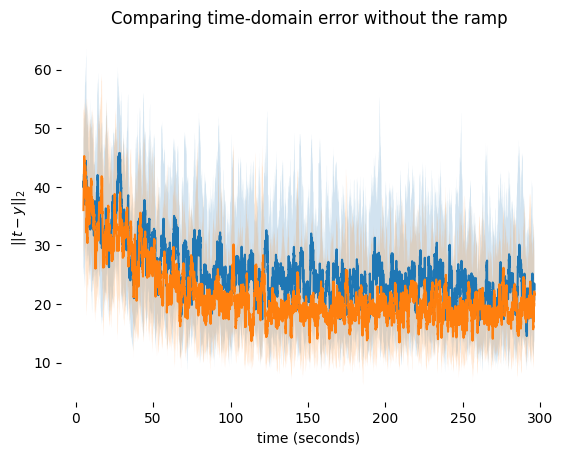

In [54]:
# Calculate the average time-domain error across all subjects

time_x = times_block1[k][c]
td_error = np.empty((2, len(keys), len(conds), min_time)) # len(update_ix)-2 so we can avoid the last interval

# get the time-domain error average across batches
for iK, key in enumerate(keys):
    for iC, cond in enumerate(conds):
        # BLOCK 1
        b = 0
        ref = refs_block1[key][iC] # ref = time x 2
        pos = poss_block1[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
        # BLOCK 2
        b = 1
        ref = refs_block2[key][iC] # ref = time x 2
        pos = poss_block2[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
# first 20 seconds after ramp 
t0_start = RAMP 
t0_end = int(tscale*25)-1 # so that both times are the same 
print("first 20 seconds after ramp, starting at index: ", t0_start, "ending at index: ", t0_end)

# take the average of the first 20 seconds across subjects, blocks and conditions
td_error_first = np.mean(td_error[:, :, :, t0_start:t0_end], axis = -1) # 2 x 7 x 8
assert(td_error_first.shape == (2, len(keys), len(conds)))

# last 20 seconds
t1_end = int(tscale*20)
print("last 20 seconds, starting at index: ", t1_end)

# make sure that the time lengths are the same
assert((t0_end - t0_start) == t1_end)

# take average of the last 20 seconds, across subjects blocks and conditions
td_error_last = np.mean(td_error[:, :, :, -t1_end:], axis=-1) # -t1_end takes the last 20 seconds index
assert(td_error_last.shape == (2, len(keys), len(conds)))

# BLOCK 1 - without the 5 seconds ramp
b = 0
td_b1_25, td_b1_50, td_bl_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b1_50)
plt.fill_between(time_x[t0_start:], td_b1_25, td_bl_75, alpha=0.2)

# BLOCK 2 - without the 5 seconds ramp
b = 1
td_b2_25, td_b2_50, td_b2_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b2_50)
plt.fill_between(time_x[t0_start:], td_b2_25, td_b2_75, alpha=0.2)

plt.title("Comparing time-domain error without the ramp")
plt.xlabel("time (seconds)")
plt.ylabel("$||t - y||_2$")
plt.box(False)

## Adapting CPHS to plot with adversarial model

In [78]:
td_b2_50.shape

(20420,)

In [55]:
print(td_b2_50[update_ix - t0_start].shape)
td_b2_50[update_ix - t0_start]

(19,)


array([18.9927478 , 40.38896868, 30.58622744, 30.56379275, 18.71611393,
       21.06245536, 27.66208124, 22.70015623, 18.41970691, 18.36723567,
       20.8748816 , 13.80956191, 17.82973326, 18.27801767, 18.71170382,
       17.9488668 , 17.93403196, 20.14721079, 21.55615049])

- Using Block 2 data for no particular reason

"Raw" user error, pulled directly

In [79]:
print(td_b2_50[update_ix - t0_start].shape)
td_b2_50[update_ix - t0_start]

(19,)


array([18.9927478 , 40.38896868, 30.58622744, 30.56379275, 18.71611393,
       21.06245536, 27.66208124, 22.70015623, 18.41970691, 18.36723567,
       20.8748816 , 13.80956191, 17.82973326, 18.27801767, 18.71170382,
       17.9488668 , 17.93403196, 20.14721079, 21.55615049])

"Smoothed" user error, taking the mean of a symmetric 50 second window

In [83]:
error_at_updates = np.zeros((19))
buffer = 100

for idx, val in enumerate(update_ix - t0_start):
    error_at_updates[idx] = td_b2_50[(val-buffer):(val+buffer)].mean()
    
print(error_at_updates.shape)
error_at_updates

(19,)


array([19.2622781 , 34.62126331, 31.32774724, 26.19949769, 21.26765242,
       19.55503462, 23.30615585, 21.01008821, 19.0067274 , 18.94775567,
       19.57127764, 17.9440607 , 19.51926325, 18.04620382, 19.70946485,
       18.26641905, 20.27111902, 19.13351575, 18.89846201])

Decoder ML Model Accuracies

In [92]:
print("BASE ML MODEL ACCURACIES")
print(lr_df.iloc[:, 2].shape)
print(np.array(lr_df.iloc[:, 2]))

print()

print("ABSOLUTE VALUE OF CHANGE BETWEEN EACH UPDATE")
abs_change = np.zeros(19)
for i in range(18):
    abs_change[i] = lr_df.iloc[i+1, 2] - lr_df.iloc[i, 2]
print(abs_change)

print()

print("PERCENT CHANGE BETWEEN EACH UPDATE")
percent_change = np.zeros(19)
for i in range(18):
    percent_change[i] = (lr_df.iloc[i+1, 2] - lr_df.iloc[i, 2])/lr_df.iloc[i, 2]
print(percent_change)

BASE ML MODEL ACCURACIES
(19,)
[2.941 2.941 29.412 41.176 55.882 52.941 67.647 73.529 67.647 76.471
 79.412 85.294 85.294 67.647 79.412 85.294 73.529 82.353 70.588]

ABSOLUTE VALUE OF CHANGE BETWEEN EACH UPDATE
[  0.     26.471  11.764  14.706  -2.941  14.706   5.882  -5.882   8.824
   2.941   5.882   0.    -17.647  11.765   5.882 -11.765   8.824 -11.765
   0.   ]

PERCENT CHANGE BETWEEN EACH UPDATE
[ 0.          9.00068004  0.3999728   0.3571498  -0.05262875  0.27778093
  0.08695138 -0.07999565  0.13044185  0.03845902  0.07406941  0.
 -0.20689615  0.17391754  0.07406941 -0.13793467  0.12000707 -0.14286061
  0.        ]


## Now plot together

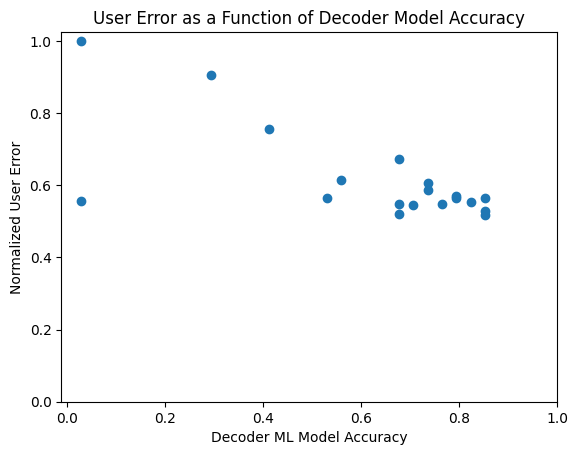

In [85]:
plt.scatter(lr_df.iloc[:, 2]/100, error_at_updates/max(error_at_updates))
plt.xlabel("Decoder ML Model Accuracy")
plt.ylabel("Normalized User Error")
plt.title("User Error as a Function of Decoder Model Accuracy")
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.show()

Add gradient to make it more clear how it evolves with time

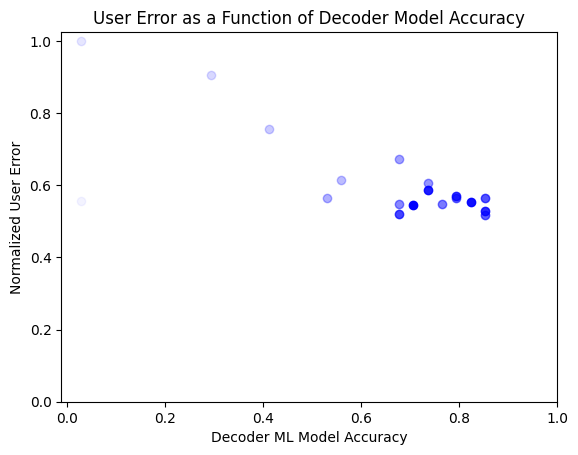

In [86]:
for i in range(19):
    plt.scatter(lr_df.iloc[i, 2]/100, error_at_updates[i]/max(error_at_updates), color='blue', alpha=(i+0.9)/19)
    
plt.xlabel("Decoder ML Model Accuracy")
plt.ylabel("Normalized User Error")
plt.title("User Error as a Function of Decoder Model Accuracy")
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.show()

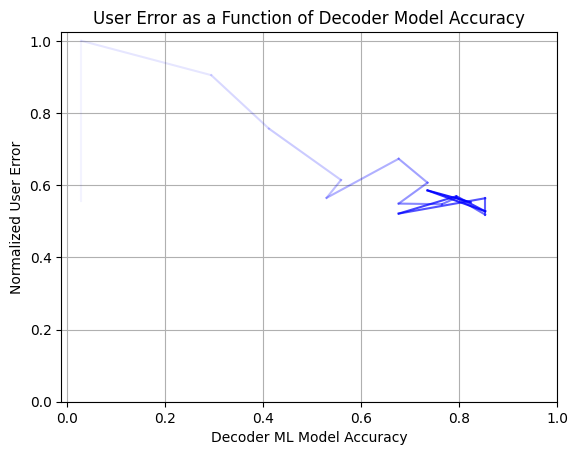

In [87]:
for i in range(17):
    plt.plot(lr_df.iloc[i:i+2, 2]/100, np.array((error_at_updates[i], error_at_updates[i+1]))/max(error_at_updates), color='blue', alpha=(i+0.9)/19)
    
plt.xlabel("Decoder ML Model Accuracy")
plt.ylabel("Normalized User Error")
plt.title("User Error as a Function of Decoder Model Accuracy")
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid()
plt.show()

These plots aren't super informative.  Let's now include the ramp and see if the another relationship becomes more apparent.  Note that keeping all dec updates is fine for Logistic Regression and SVC, but not for other models (see NB 104).

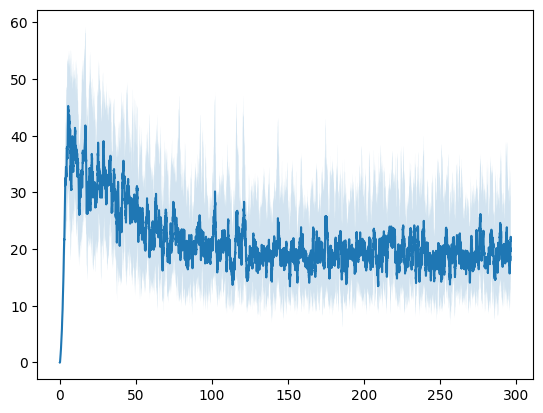

In [64]:
# BLOCK 2 - KEEPTING the 5 seconds ramp
b = 1
td_b2_25_NR, td_b2_50_NR, td_b2_75_NR = np.percentile(td_error[b, :, :, :], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[:], td_b2_50_NR)
plt.fill_between(time_x[:], td_b2_25_NR, td_b2_75_NR, alpha=0.2)
plt.show()

Not worth plotting against dec acc, the ramp is the wrong trend (error ought to be higher at th beginning). I see why we remove it.

In [72]:
print("Seconds per decoder update: ")
5*60/19

Seconds per decoder update: 


15.789473684210526

In [73]:
print("RAMP time dropped: ")
350/20770*5*60

RAMP time dropped: 


5.055368319691864

Each decoder update is about 16 seconds.  The original user error plots have a ramp term (~5 second data drop from the front).  Intuitively (just from looking at the dec model graph and the CPHS, the dec model acc plateaus around update 9-12 (e.g. 142-189 seconds), whereas the CPHS error graph appears to plateau much earlier, around 60-80 seconds, so we would expect the initial relationship to be "sub-linear", ideally taking the shape of exponential decay.

## Try Flipping the Axes

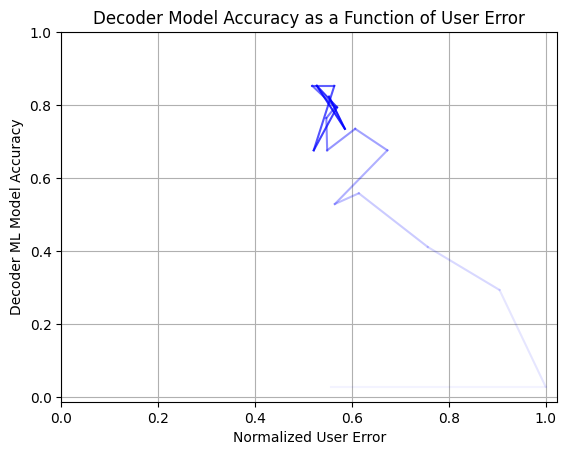

In [88]:
for i in range(17):
    plt.plot(np.array((error_at_updates[i], error_at_updates[i+1]))/max(error_at_updates), lr_df.iloc[i:i+2, 2]/100, color='blue', alpha=(i+0.9)/19)
    
plt.ylabel("Decoder ML Model Accuracy")
plt.xlabel("Normalized User Error")
plt.title("Decoder Model Accuracy as a Function of User Error")
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid()
plt.show()

Still not super insightful

Just for fun look at the other vectors we defined with respect to the amount of change between updates

In [104]:
abs_error_change = np.zeros(19)
for i in range(18):
    abs_error_change[i] = error_at_updates[i+1] - error_at_updates[i]
print(abs_error_change)

[15.35898521 -3.29351607 -5.12824955 -4.93184528 -1.7126178   3.75112124
 -2.29606765 -2.00336081 -0.05897173  0.62352197 -1.62721693  1.57520255
 -1.47305943  1.66326103 -1.44304579  2.00469997 -1.13760327 -0.23505374
  0.        ]


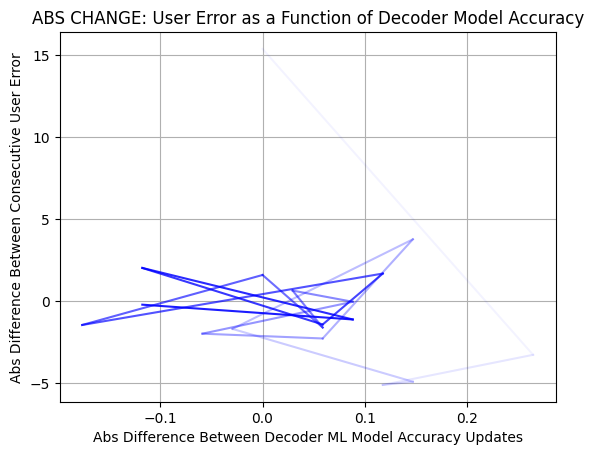

In [112]:
for i in range(17):
    plt.plot(abs_change[i:i+2]/100, abs_error_change[i:i+2], color='blue', alpha=(i+0.9)/19)
    
plt.xlabel("Abs Difference Between Decoder ML Model Accuracy Updates")
plt.ylabel("Abs Difference Between Consecutive User Error")
plt.title("ABS CHANGE: User Error as a Function of Decoder Model Accuracy")
#plt.xticks(np.arange(0, 1.2, 0.2))
#plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid()
plt.show()

In [109]:
percent_error_change = np.zeros(19)
for i in range(18):
    percent_error_change[i] = (error_at_updates[i+1] - error_at_updates[i])/error_at_updates[i]
print(percent_error_change)

[ 0.79736079 -0.09512986 -0.16369672 -0.18824198 -0.08052688  0.19182381
 -0.09851765 -0.09535233 -0.00310268  0.03290743 -0.08314311  0.08778406
 -0.07546696  0.09216681 -0.07321588  0.10974784 -0.05611941 -0.01228492
  0.        ]


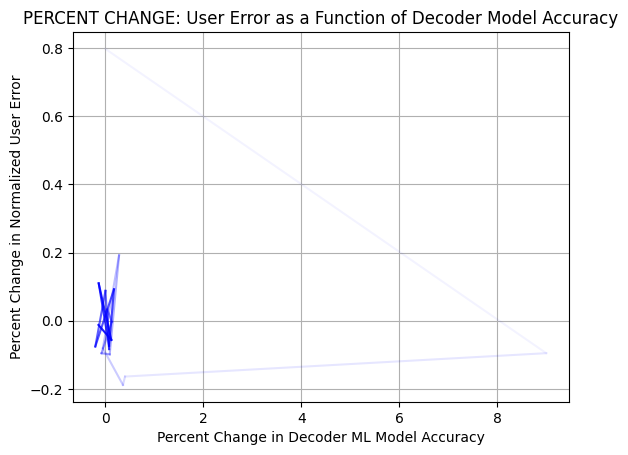

In [110]:
for i in range(17):
    plt.plot(percent_change[i:i+2], percent_error_change[i:i+2], color='blue', alpha=(i+0.9)/19)
    
plt.xlabel("Percent Change in Decoder ML Model Accuracy")
plt.ylabel("Percent Change in Normalized User Error")
plt.title("PERCENT CHANGE: User Error as a Function of Decoder Model Accuracy")
#plt.xticks(np.arange(0, 1.2, 0.2))
#plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid()
plt.show()

Also not useful